# Importing packages and load CNN

In [1]:
import pykat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import cm
# import keras
# from keras import backend as k
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# import tensorflow as tf
# import pickle
from copy import deepcopy
from tqdm import tqdm
import datetime
import time
import os

# from pykat.optics.gaussian_beams import HG_mode
# from pykat.optics.gaussian_beams import BeamParam
import pykat.optics.gaussian_beams as gb
from math import factorial
from scipy.special import comb

plt.style.use('seaborn-pastel')
# Telling the notebook to make plots inline.
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

                                              ..-
    PyKat 1.1.331         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat




# Initialization

In [2]:
n_pixl = 128
tilt_step = 1e-4
RepoDir = '/home/user1/Dropbox/Academic/WORK/Beam_auto_alignment'
ImagesFolder = RepoDir + '/Data/FINESSE_Fittest_points_per_gen_' + \
str(datetime.datetime.now()).replace(' ', '_').replace(':', '-')[:-10]
if not os.path.exists(ImagesFolder): os.mkdir(ImagesFolder)
# SaveModelFolder = '/home/user1/Dropbox/Academic/WORK/Beam_auto_alignment/Data/TrainedModels/'
# Model_Name = 'Trained_Model_2019-07-03_17-15'

# # Read the pre-trained CNN model
# cnn = keras.models.load_model(SaveModelFolder + Model_Name + '.h5')
# # load the encoder
# loaded_Encoder = pickle.load(open(SaveModelFolder + 'Encoder_of_' + Model_Name + '.npy', 'rb'))

#seed
np.random.seed(198)
# waist size in m
waist = 140e-6
# range of movement of the waist center at the waist location in the units of waist size
Range = 3.5
# cumulative distance of waist from SM1 in m
d1 = 0.35+0.0884
# cumulative distance of waist from SM2 in m
d2 = 0.0884
scale_params = np.array([waist/d1, waist/d1, waist/d2, waist/d2, 90.])
# Scale for initial random misalignment in the units of waist size
a = 3.
pop_per_gen = 300
num_generations = 25
num_params = len(scale_params)
num_parents_mating = pop_per_gen // 10 	# 10% of new population is parents
# No of possible pairs of parents (repetition allowed)
num_parent_pairs = comb(num_parents_mating, 2, exact=True, repetition=True)
num_offsprings_per_pair = (pop_per_gen - num_parents_mating) // num_parent_pairs + 1
# after each iteration, range shrinks by
shrink_factor = 2. / pop_per_gen ** 0.25  # make sure it is < 1.
# Defining the population size.
pop_size = (pop_per_gen,num_params) # The population will have sol_per_pop chromosome \
# where each chromosome has num_weights genes.
fitness = np.empty(pop_per_gen)

# plotting 
ms = 7
ms_datum = 14

## Define Functions

In [3]:
def sample_d(Rng, shape=pop_size):
    """
    Takes i/p range in umits of beam waist at the waist location.
    Outputs sets of deltas (in radians) to be fed to steering mirrors.
    O/P shape : pop_size
    """
    delta = np.random.uniform(low=-Rng, high=Rng, size=shape)
    delta *= scale_params
    return delta

def Reward(Beam_status, return_img=False):
    # reward fn as total power
    base.SM1.xbeta = Beam_status[0]
    base.SM1.ybeta = Beam_status[1]
    base.SM2.xbeta = Beam_status[2]
    base.SM2.ybeta = Beam_status[3]
    base.M2.phi = Beam_status[4]
    Img1, out = beam_profile(base, x, y)
    R_fn1 = Img1.sum()*100/n_pixl**2/Max_P
    return R_fn1, Img1

def calc_pop_fitness(Current_beam_status, New_pop_deltas, fitness, only_offsprings=False):
    """
    Calculating the fitness value of each solution in the current population.
    Also returns the current beam location (after adding the steps taken so far)
    """
    if only_offsprings:
        range_vals = range(num_parents_mating, pop_per_gen)
    else:
        range_vals = range(pop_per_gen)
    for ii in range_vals:
        # take the delta step
        Current_beam_status += New_pop_deltas[ii]
        # cumulatively subtracting each delta step from all deltas
        New_pop_deltas -= New_pop_deltas[ii]
        R_new, _ = Reward(Current_beam_status, return_img=False)
        fitness[ii] = R_new
    return Current_beam_status, New_pop_deltas, fitness

def select_mating_pool(pop, fitness, num_parents_mating, show_the_best=False, save_best=False):
    """
    Selecting the best candidates in the current generation as parents for 
    producing the offspring of the next generation.
    """
    parents = np.empty((num_parents_mating, num_params))
    isort = np.argsort(fitness)[::-1]
    parents_fitness = fitness[isort][:num_parents_mating]
    parents = pop[isort][:num_parents_mating,:]
    if show_the_best:
        t1 = time.time() - t0
        print('Time: {}, Fittest Parent: {}, Fitness: {}'.format(t1, parents[0], parents_fitness[0]))
        _, Img = Reward(parents[0], return_img=True)
        plt.imshow(Img[::-1], cmap=cm.binary_r)
        plt.colorbar()
        if save_best:
            if gen < 10:
                plt.savefig(ImagesFolder + '/Gen_0%d_time_%d_Power_%1.2f_alignments_%f_%f_%f_%f_endMirror_%f.png' \
                     %(gen, (t1), parents_fitness[0], parents[0][0], \
                       parents[0][1], parents[0][2], parents[0][3], parents[0][4]))
            else:
                plt.savefig(ImagesFolder + '/Gen_%d_time_%d_Power_%1.2f_alignments_%f_%f_%f_%f_endMirror_%f.png' \
                     %(gen, (t1), parents_fitness[0], parents[0][0], \
                       parents[0][1], parents[0][2], parents[0][3], parents[0][4]))
        plt.show()
    return parents, parents_fitness

def get_offsprings_Uniform(pairs, parents, offspring_size):
    """create offsprings using uniform crossover"""
    offsprings = np.empty(offspring_size)
    nn = 0
    for i in range(len(pairs)):
        for j in range(num_offsprings_per_pair):
            if nn == offspring_size[0] : break
            while True:
                # To make sure not all True/False
                i_select_genes = np.random.choice([True, False], num_params)
                if (i_select_genes.sum() != num_params) & (i_select_genes.sum() != 0): break
            offsprings[nn][i_select_genes] = parents[pairs[i][0]][i_select_genes]
            offsprings[nn][np.logical_not(i_select_genes)] = \
            parents[pairs[i][1]][np.logical_not(i_select_genes)]
            nn += 1
    return offsprings

def crossover(parents, offspring_size):
    # get all possible pairs
    pairs = []
    for p1 in range(num_parents_mating):
        for p2 in range(p1, num_parents_mating):
            pairs.append([p1,p2])
    pairs = np.array(pairs)
    # Give preference to combinations of top performing parents
    i_sort = np.argsort(pairs.sum(axis=1))
    pairs = pairs[i_sort]
    offsprings = get_offsprings_Uniform(pairs, parents, offspring_size)
    return offsprings

def mutation(Offspring_crossover, Rng):
    # Mutation changes a single gene in each offspring randomly.
    mutations = sample_d(Rng, shape=Offspring_crossover.shape)
    # The random value to be added to the gene.
    Offspring_crossover += mutations
    return Offspring_crossover

def ads(N, node):
    '''
    Returns Finesse code for amplitude detectors for all modes 
    up to, and including, order N.
    '''
    txt = 'ad HG{0}{1} {0} {1} 0 '
    txt += '{}\n'.format(node)
    code = ''
    for k in range(N+1):
        for i in range(N-k+1):
            code += txt.format(k,i)
    return code

def bps(node):
    '''
    Adding beam parameter detectors for qx and qy
    '''
    txt = 'bp qx x q {0}\nbp qy y q {0}'.format(node)
    return txt

def q2w(q, lambd = 1.064e-6):
    return np.sqrt(lambd*np.abs(q)**2/(np.pi*q.imag))
    
def q2Rc(q):
    return np.abs(q**2)/q.real

def q2gouy(q):
    return np.arctan(q.real/q.imag)

def herm(n,x):
    # Returns Hn(x), i.e., data from hermitan polynomial of order n.
    coef = np.zeros(n+1)
    coef[-1] = 1
    h = np.polynomial.hermite.hermval(x,coef)
    return h

def Un(n, x, q, lambd = 1.064e-6):
    w = q2w(q)
    Rc = q2Rc(q)
    gouy = q2gouy(q)
    
    const = np.sqrt( np.sqrt(2)/(factorial(n)*np.sqrt(np.pi)*w*2**n))
    G = np.exp(1j*(2.0*n+1.0)*gouy/2.0)
    H = herm(n, (np.sqrt(2)/w) * x )
    E = np.exp( (-1.0/w**2 - 1j*np.pi/(lambd*Rc))*x**2 )
    return const*G*H*E

def Unm(x,y,n,m,qx,qy):
    return np.outer(Un(n,x,qx), Un(m,y,qy))

def beam_profile(kat_object, x, y, verbose=False):
    '''
    Generated intensity data on a grid defined by x and y. The kat_object
    must contain beam parameter detectors detecting qx and qy, and it needs
    to have amplitude detectors for all spatial modes within the maxtem. 
    These can be added using ads() and bps() above. 
    '''
    kat = kat_object.deepcopy()
    N = kat.maxtem

    out = kat.run()
    
    qx = out['qx']
    qy = out['qy']
    gouy_x = q2gouy(qx)

    A = 0
    for n in range(N+1):
        for m in range(N-n+1):
            a = out['HG{}{}'.format(n,m)]*np.exp(-1j*gouy_x*(n+m))            
            A += a*Unm(x,y,n,m,qx,qy).transpose()
    if verbose:
        print('Finesse run: {:.3f} s'.format(t_run))
    return np.abs(A)**2, out

def Plot_pop(new_pop_deltas, Rng, Fitness, show_parents=True, save_plots=True):
    styl = 'g+'
    if show_parents: styl = 'bo'
    plt.figure(figsize=(10,15))
    # SM1
    plt.subplot(311)
    plt.title('Best Power: %1.2f' %Fitness[0] + ' \%')
    plt.plot(new_pop_deltas[:num_parents_mating,0], new_pop_deltas[:num_parents_mating,1], \
             styl, alpha=0.5, markersize=ms, label='SM1-Parents')
    plt.plot(new_pop_deltas[num_parents_mating:,0], new_pop_deltas[num_parents_mating:,1], \
             'g+', alpha=0.5, markersize=ms, label='SM1-Offsprings')
    plt.plot([0], [0], 'm*', markersize=ms_datum)
    plt.xlim([-Rng*scale_params[0], Rng*scale_params[0]])
    plt.ylim([-Rng*scale_params[0], Rng*scale_params[0]])
    plt.xlabel(r'$\phi_{ SM1}^x$ (rad)')
    plt.ylabel(r'$\phi_{ SM1}^y$ (rad)')
    plt.legend()
    # SM2
    plt.subplot(312)
    plt.plot(new_pop_deltas[:num_parents_mating,2], new_pop_deltas[:num_parents_mating,3], \
             styl, alpha=0.5, markersize=ms, label='SM2-Parents')
    plt.plot(new_pop_deltas[num_parents_mating:,2], new_pop_deltas[num_parents_mating:,3], \
             'g+', alpha=0.5, markersize=ms, label='SM2-Offsprings')
    plt.plot([0], [0], 'm*', markersize=ms_datum)
    plt.xlim([-Rng*scale_params[2], Rng*scale_params[2]])
    plt.ylim([-Rng*scale_params[2], Rng*scale_params[2]])
    plt.xlabel(r'$\phi_{ SM2}^x$ (rad)')
    plt.ylabel(r'$\phi_{ SM2}^y$ (rad)')
    plt.legend()
    # CM2
    plt.subplot(313)
    plt.plot(new_pop_deltas[:num_parents_mating,4], np.zeros(num_parents_mating), \
             styl, alpha=0.5, markersize=ms, label='CM2-Parents')
    plt.plot(new_pop_deltas[num_parents_mating:,4], np.zeros(pop_per_gen-num_parents_mating), \
             'g|', alpha=0.5, markersize=ms, label='CM2-Offsprings')
    plt.plot([0], [0], 'm*', markersize=ms_datum)
    plt.xlim([-Rng*scale_params[4], Rng*scale_params[4]])
    plt.xlabel(r'$\phi_{ CM2}^z$ (deg)')
    plt.legend()
    if save_plots:
        if gen < 10:
            plt.savefig(ImagesFolder + '/scatter_plot_Gen_0%d.png' %(gen))
        else:
            plt.savefig(ImagesFolder + '/scatter_plot_Gen_%d.png' %(gen))
    plt.show()

# Base Model

In [4]:
base = pykat.finesse.kat()
base.verbose = False
base.parse("""

# Input laser
# -----------------------------
l laser 1e-2 0 n0            # Laser (Power = 10 mW, wavelength offset = 0)

# Gaussian Beam
gauss GB laser n0 129e-6 0   # define beam waist

s s00 0.21801 n0 nL1a         # Space (Length = 0.218 m)

# Lens of f=150mm
lens Lns 0.150 nL1a nL1b

s s0 0.032 nL1b nSM1a        # Space (Length = 0.032 m)

# Steering mirrors
# -----------------------------
bs SM1 1 0 0 45 nSM1a nSM1b nSM1c nSM1d  # Beam splitter (R=1, T=0, phi(tuning)=0, alpha=45)

s s1 0.35 nSM1b nSM2a

bs SM2 1 0 0 45 nSM2a nSM2b nSM2c nSM2d

s s2 0.0884 nSM2b nM1a

# Cavity
# -----------------------------
# cavity mirror1 (R=0.95, T=0.05, phi=0)
m M1 0.95 0.05 0 nM1a nM1b

# cavity length 122.7mm for waist 140um
s lCav 0.1227 nM1b nM2a

# cavity mirror2 (R=0.99, T=0.01, phi=0)
m M2 0.99 0.01 0 nM2a nM2b

# Setting RoC of M2
attr M2 Rc 0.150

# Defning the cavity for spatial mode basis computation
cav cav1 M1 nM1b M2 nM2a

# Output
# -----------------------------
s sOut 0.1 nM2b nOut

# Photo diode
pd P nOut

# Amplitude detector
# ad AD11 1 1 1064 nOut

# Beam camera
# beam CCD nOut

# max order of modes
maxtem 4
""")

Maximum Power (in image) (at perfect alignment): 215.83290984516728


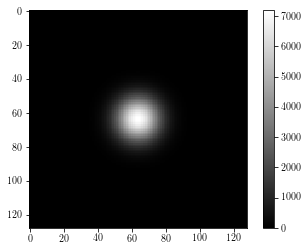

In [5]:
node = 'nOut'
# Parsing amplitude detectors
base.parse(ads(base.maxtem, node))
# Parsing beam parameter detectors
base.parse(bps(node))
# Simulation instructions
base.parse('''
noxaxis
yaxis abs:deg
''')
xlims = np.array([-1.0, 1.0])*2e-3
ylims = np.array([-1.0, 1.0])*2e-3
# Creating x and y arrays
x = np.linspace(xlims[0], xlims[1], n_pixl)
y = np.linspace(ylims[0], ylims[1], n_pixl)
# Calculate max transmitted power at perfect alignment
base.M2.phi = 0.
base.SM1.xbeta = 0.
base.SM1.ybeta = 0.
base.SM2.xbeta = 0.
base.SM2.ybeta = 0.
Img_initial, out = beam_profile(base, x, y)
Max_P = Img_initial.sum()/n_pixl**2
    
print('Maximum Power (in image) (at perfect alignment): {}'.format(Max_P))
plt.imshow(Img_initial[::-1], cmap=cm.binary_r)
plt.colorbar()

## Initial misalignment

In [6]:
# give angle in radian
current_beam_status = np.random.uniform(low=-a, high=a, size=(num_params,))
current_beam_status *= scale_params
print(current_beam_status)

[ 2.10386254e-04  8.79298381e-04 -1.82742785e-03 -4.17707457e-03
 -7.12312979e+01]




Range: 3.5 x waist


 Gen: 0 Range: 1.681967989894328 x waist


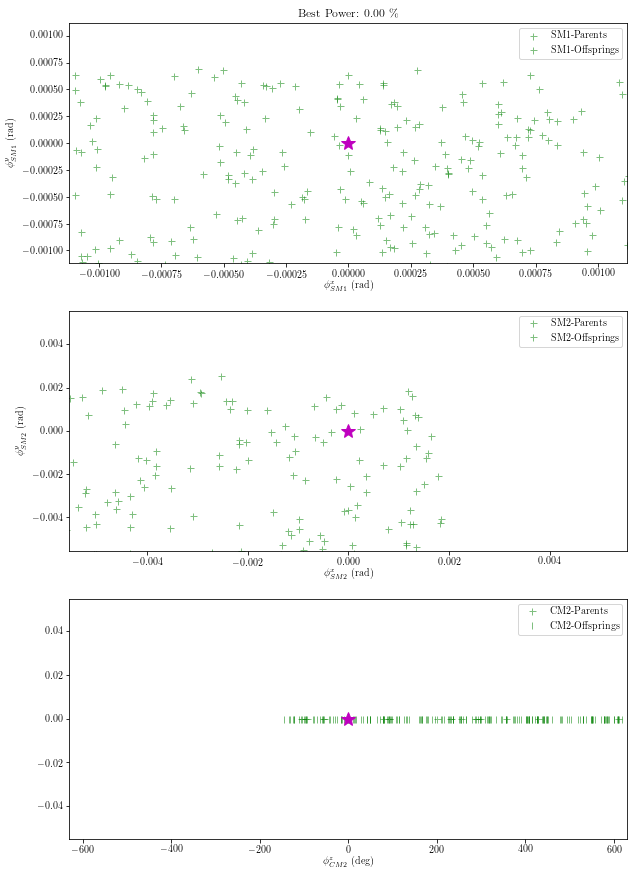

Time: 13.219995498657227, Fittest Parent: [ 1.49715234e-04 -9.00005731e-04 -2.16429054e-03 -4.01466384e-04
  1.76713385e+02], Fitness: 0.6790799403836265


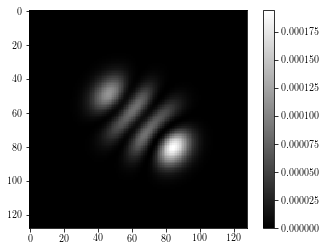



 Gen: 1 Range: 0.8082903768654762 x waist


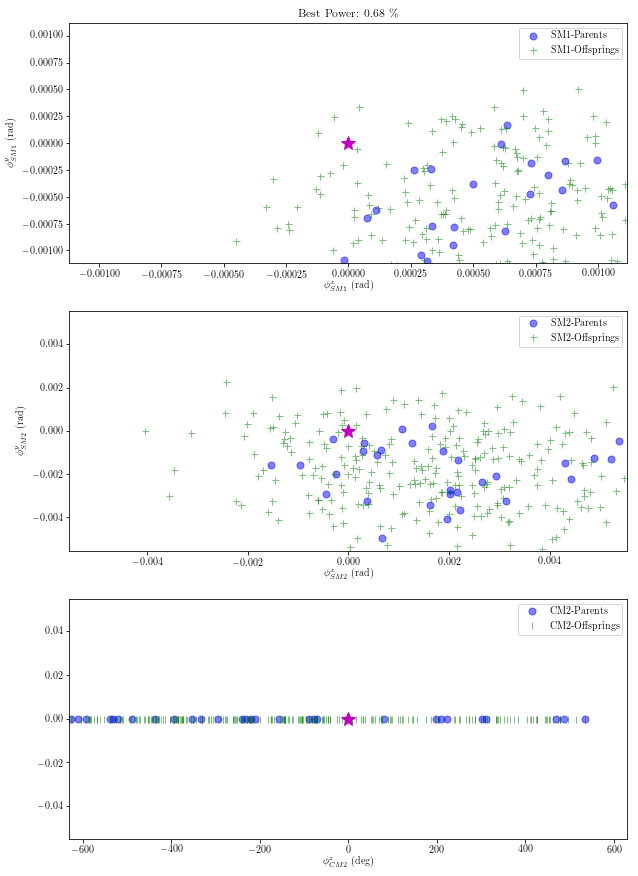

Time: 25.32185935974121, Fittest Parent: [ 7.18709368e-04 -7.19976585e-04  8.89400919e-04 -2.91263036e-03
 -5.61143336e+01], Fitness: 7.446918621830859


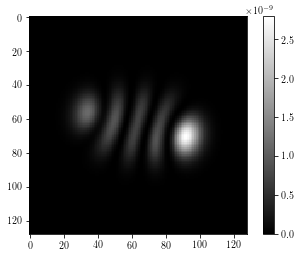



 Gen: 2 Range: 0.3884338686935297 x waist


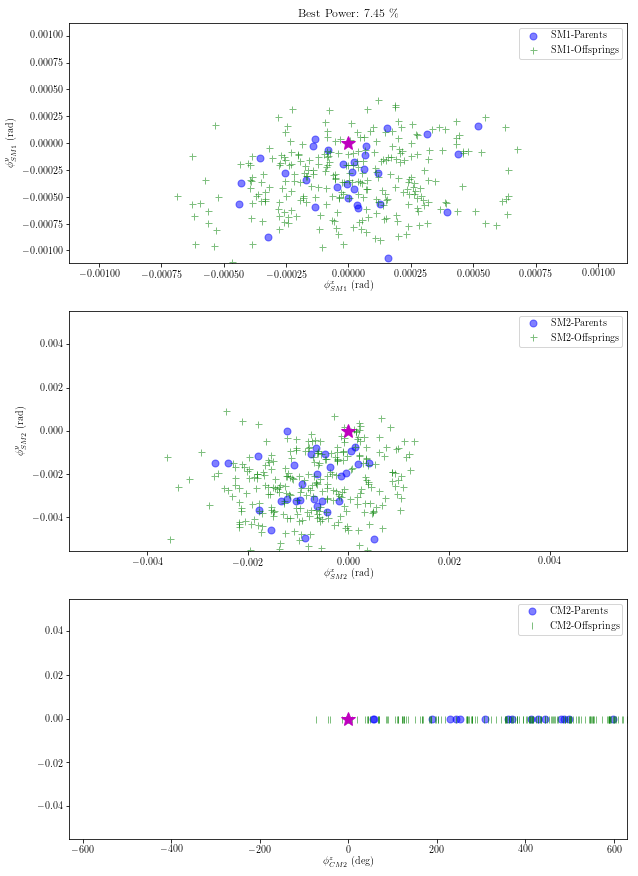

Time: 37.65924787521362, Fittest Parent: [ 1.12443069e-04 -6.55056367e-04 -5.62399567e-04 -4.82009256e-04
  3.16143824e+02], Fitness: 33.58901575627427


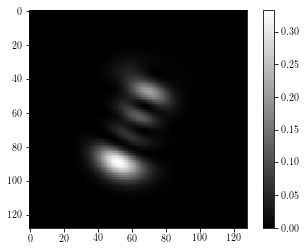



 Gen: 3 Range: 0.18666666666666673 x waist


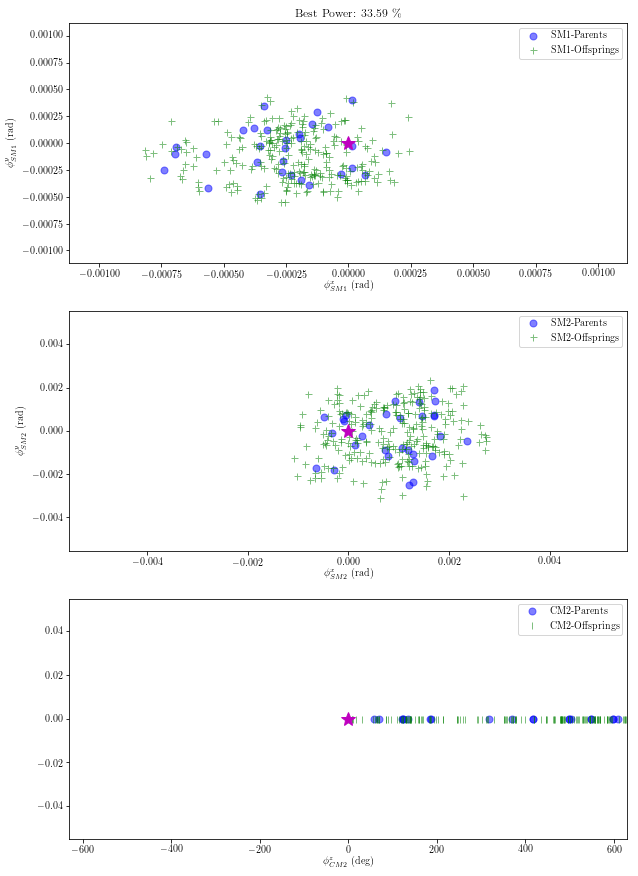

Time: 50.08630681037903, Fittest Parent: [-1.89285744e-04 -3.40208278e-04  9.27756271e-04  1.38507083e-03
  3.16762941e+02], Fitness: 33.58901575627427


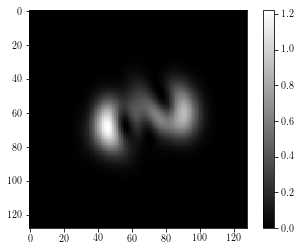



 Gen: 4 Range: 0.08970495946103087 x waist


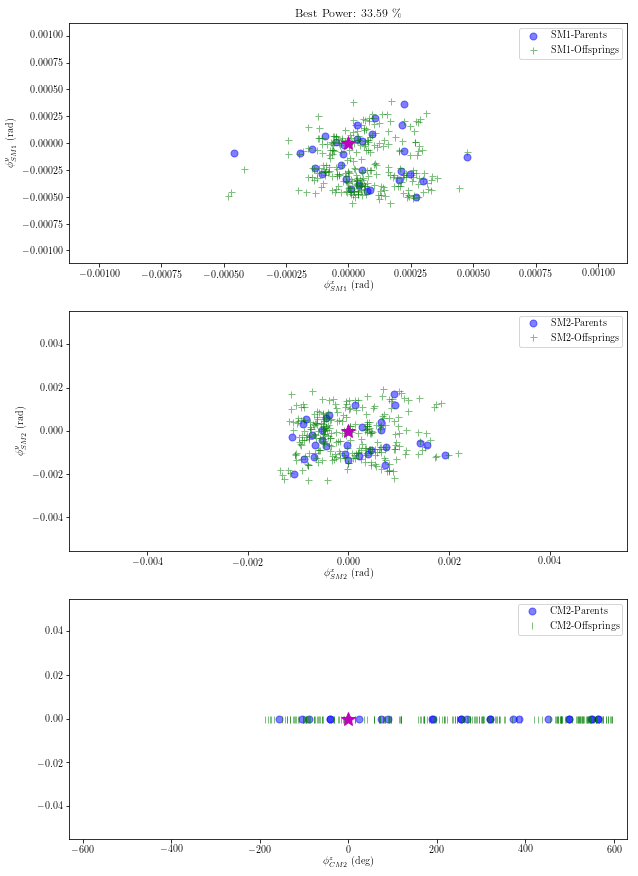

Time: 62.92482829093933, Fittest Parent: [-1.98406112e-06 -2.55907458e-04  4.35343054e-04 -9.26060347e-04
  9.88088403e+02], Fitness: 40.03908812374838


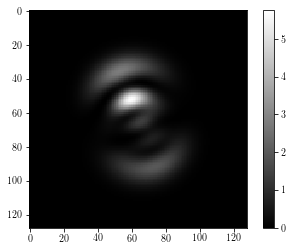



 Gen: 5 Range: 0.04310882009949208 x waist


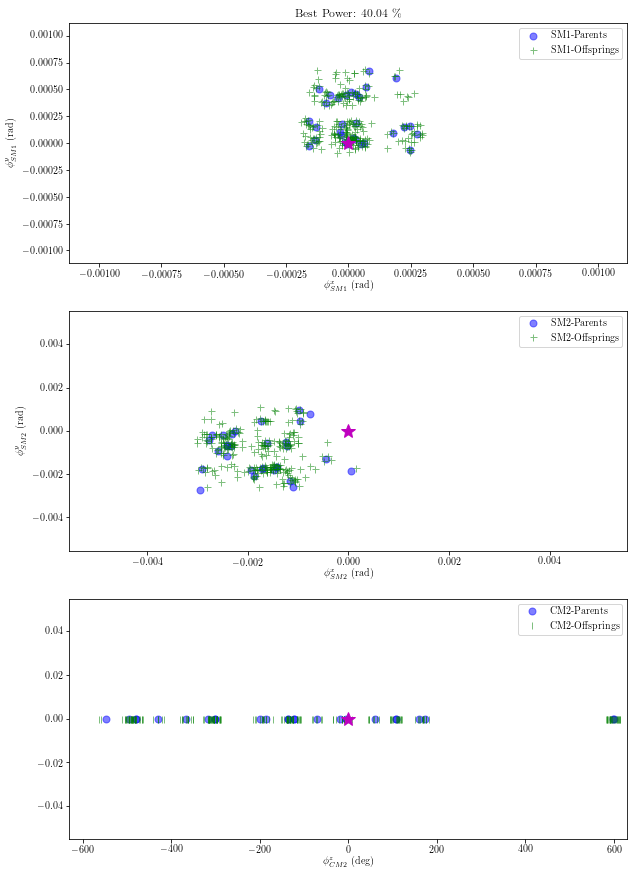

Time: 75.50061821937561, Fittest Parent: [-2.63858356e-05  1.82581691e-04 -1.43707351e-03 -1.66843797e-03
  5.97973211e+02], Fitness: 40.03908812374838


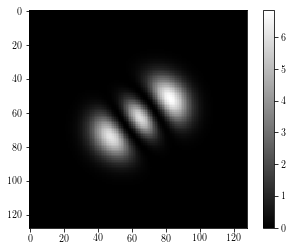



 Gen: 6 Range: 0.02071647299698826 x waist


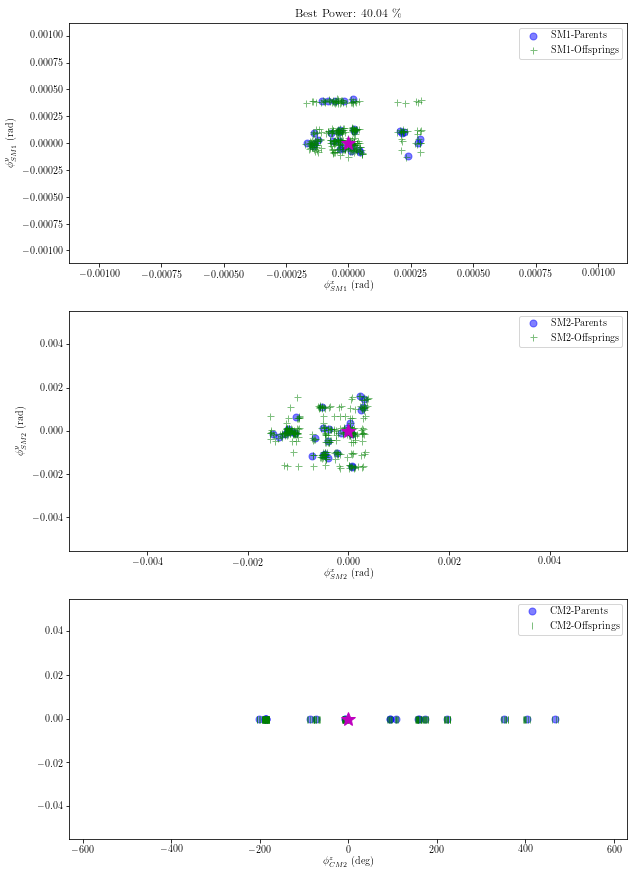

Time: 87.82553791999817, Fittest Parent: [-7.16326622e-05  2.45803099e-05 -1.12267111e-04 -1.26669197e-04
  8.92599680e+02], Fitness: 80.79383509908033


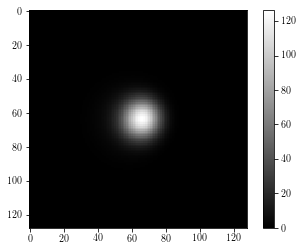



 Gen: 7 Range: 0.009955555555555563 x waist


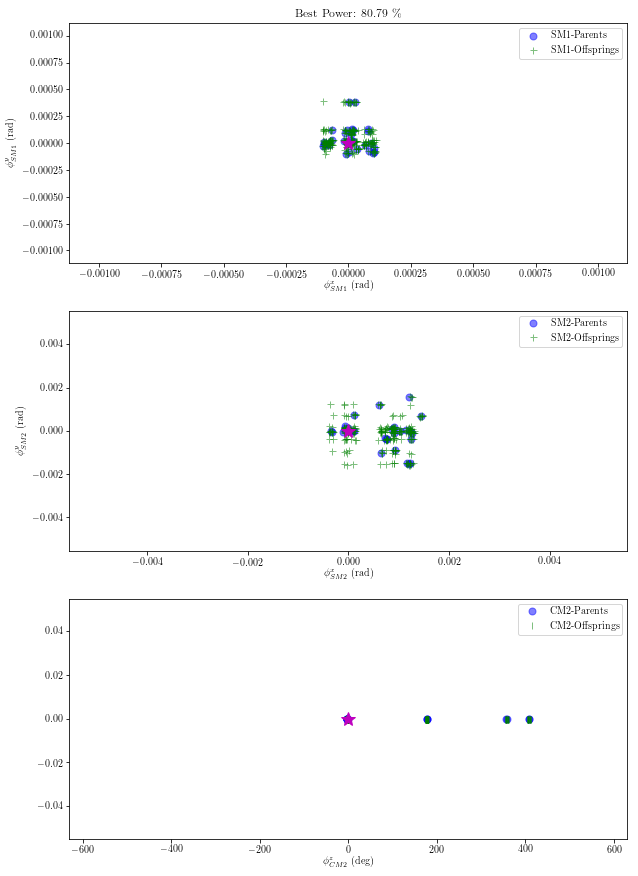

Time: 100.33428406715393, Fittest Parent: [ 1.62338946e-05  1.33817386e-04  8.36956918e-04 -3.98155796e-04
  1.07742529e+03], Fitness: 97.10738591887741


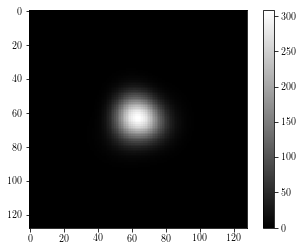



 Gen: 8 Range: 0.004784264504588315 x waist


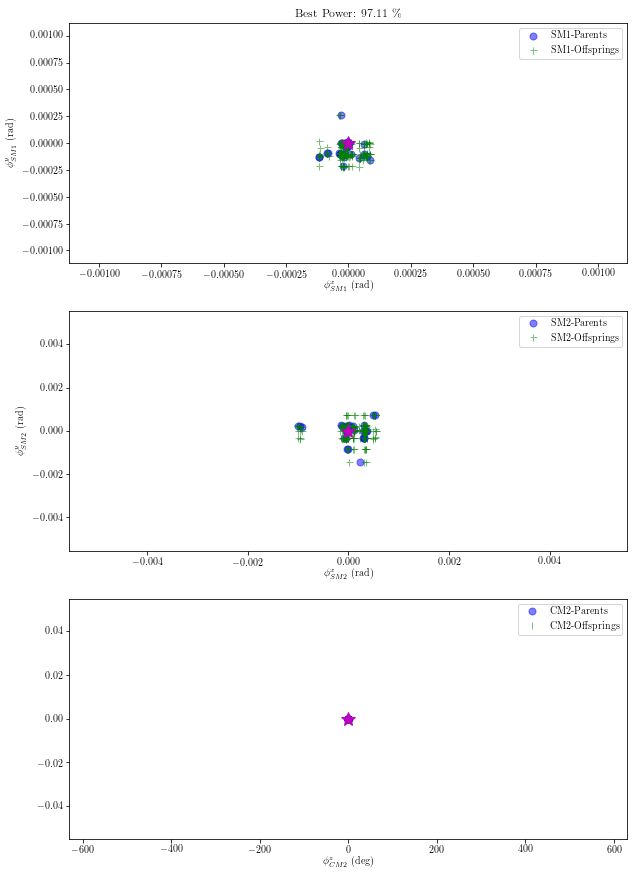

Time: 112.80442523956299, Fittest Parent: [-2.05514424e-06  1.28026626e-05 -8.61425432e-05 -3.36377890e-04
 -2.27927170e-01], Fitness: 97.10738591887741


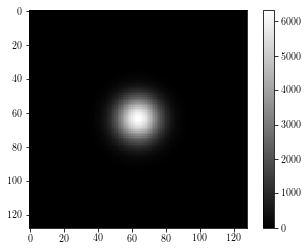



 Gen: 9 Range: 0.0022991370719729117 x waist


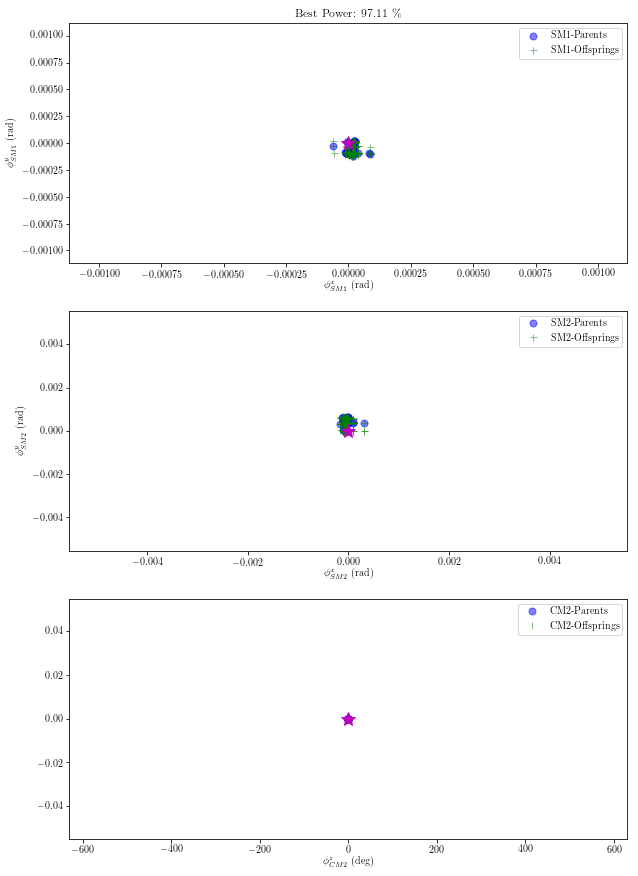

Time: 125.15981006622314, Fittest Parent: [ 2.63321563e-05  1.99298024e-05 -9.61683774e-05  2.41341147e-05
 -1.31560941e-01], Fitness: 97.63609323906812


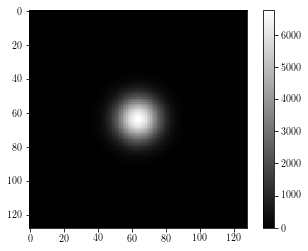



 Gen: 10 Range: 0.0011048785598393742 x waist


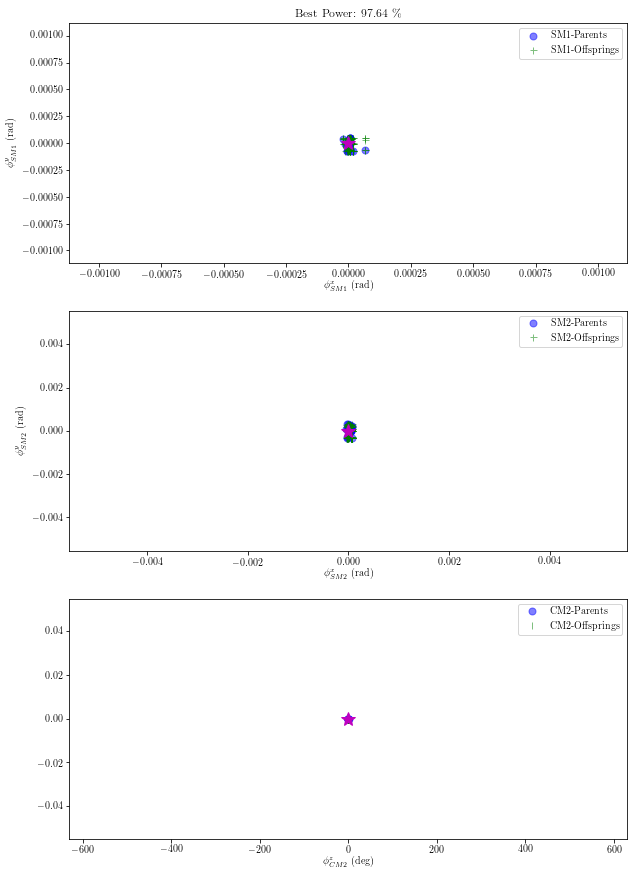

Time: 137.4786674976349, Fittest Parent: [ 3.60758859e-07 -4.77248758e-06 -4.14151712e-05 -4.65054413e-06
  1.08024032e+03], Fitness: 98.13901844472834


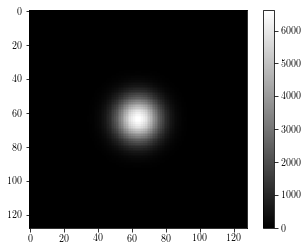



 Gen: 11 Range: 0.0005309629629629635 x waist


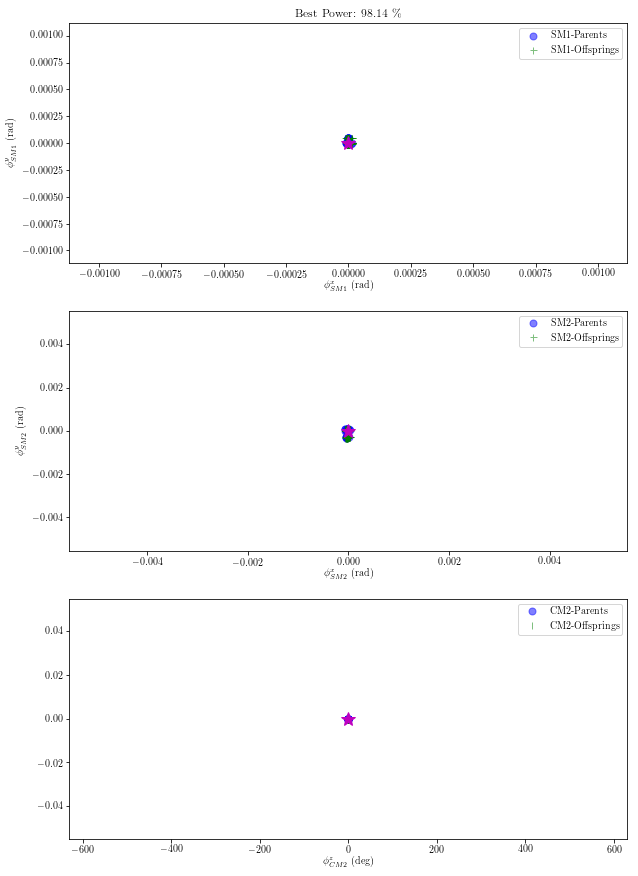

Time: 149.66325640678406, Fittest Parent: [ 1.25606077e-05 -3.99028533e-06 -4.00119265e-05  5.64378487e-06
 -5.41141769e-02], Fitness: 98.95368852166774


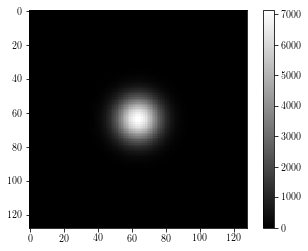



 Gen: 12 Range: 0.00025516077357804357 x waist


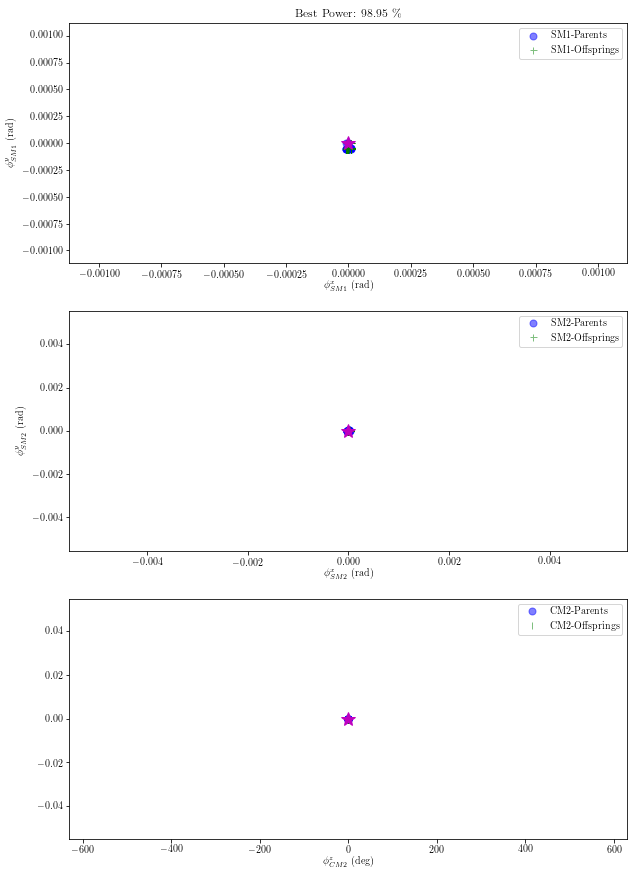

Time: 161.84529280662537, Fittest Parent: [ 1.19401615e-05 -4.78450444e-05 -2.54966128e-06  2.19609663e-06
 -1.07994853e+03], Fitness: 99.071384501348


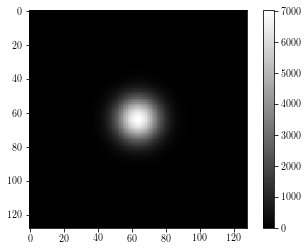



 Gen: 13 Range: 0.00012262064383855535 x waist


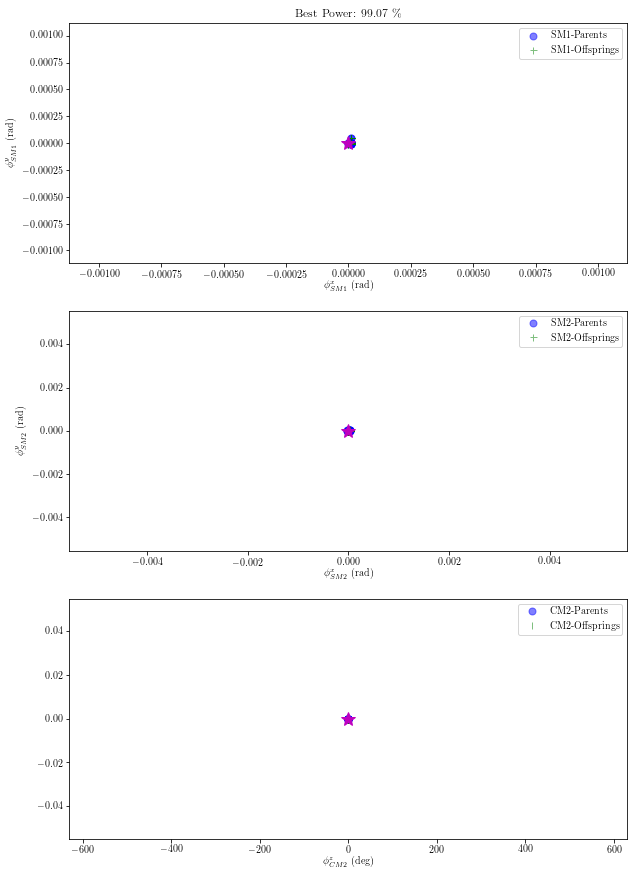

Time: 173.98493099212646, Fittest Parent: [1.25712648e-05 1.26854543e-06 2.30295597e-06 5.82432177e-07
 5.09543415e-02], Fitness: 99.17010547883959


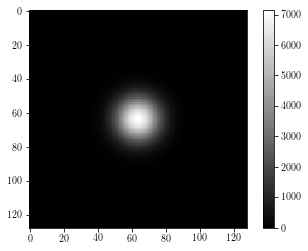



 Gen: 14 Range: 5.892685652476665e-05 x waist


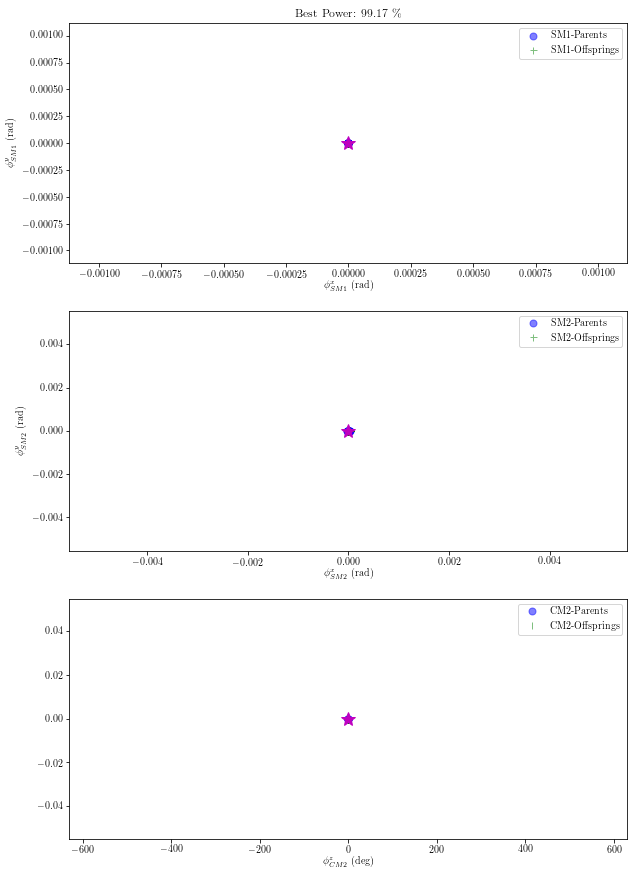

Time: 186.0881860256195, Fittest Parent: [-2.55479349e-08  6.29083441e-07  1.62529652e-06 -1.11527360e-06
  1.07999041e+03], Fitness: 99.17315236877681


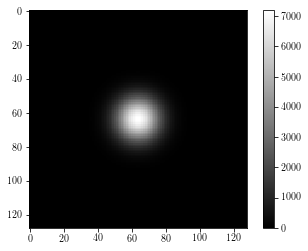



 Gen: 15 Range: 2.8318024691358068e-05 x waist


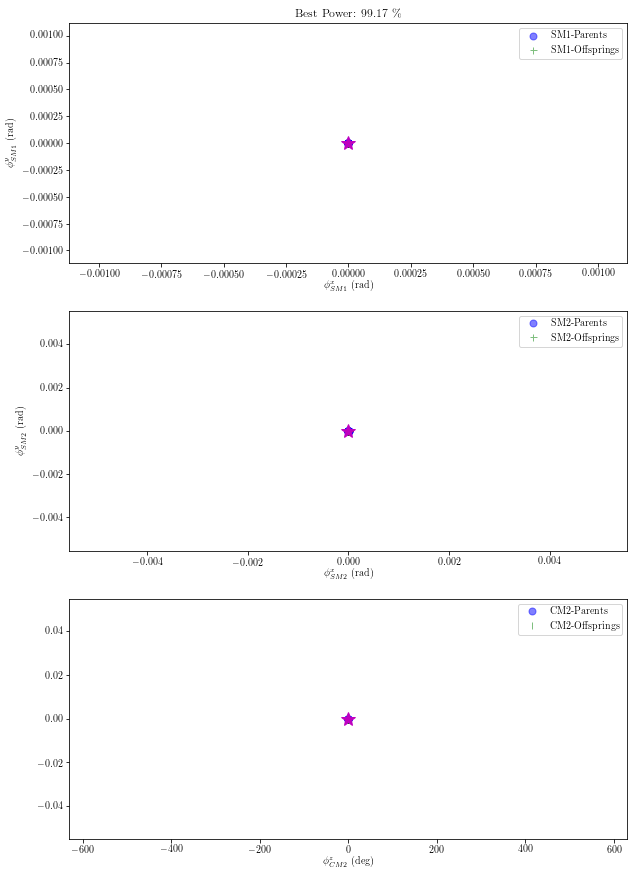

Time: 198.20465922355652, Fittest Parent: [ 6.97345684e-08  4.68800145e-08  6.90517888e-06 -5.36081537e-06
  1.08000517e+03], Fitness: 99.17529856602283


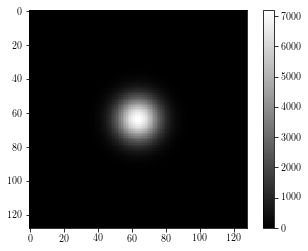



 Gen: 16 Range: 1.3608574590828995e-05 x waist


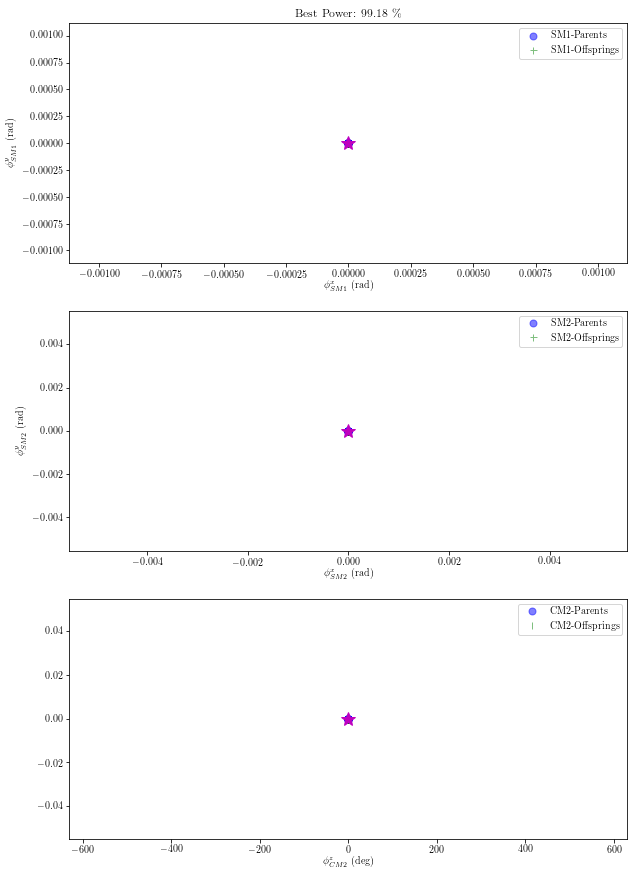

Time: 210.2791724205017, Fittest Parent: [ 6.28657080e-08  1.62825109e-08 -1.94262373e-06 -4.90890334e-06
 -3.54242535e-03], Fitness: 99.18282814452759


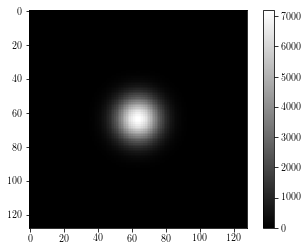



 Gen: 17 Range: 6.539767671389621e-06 x waist


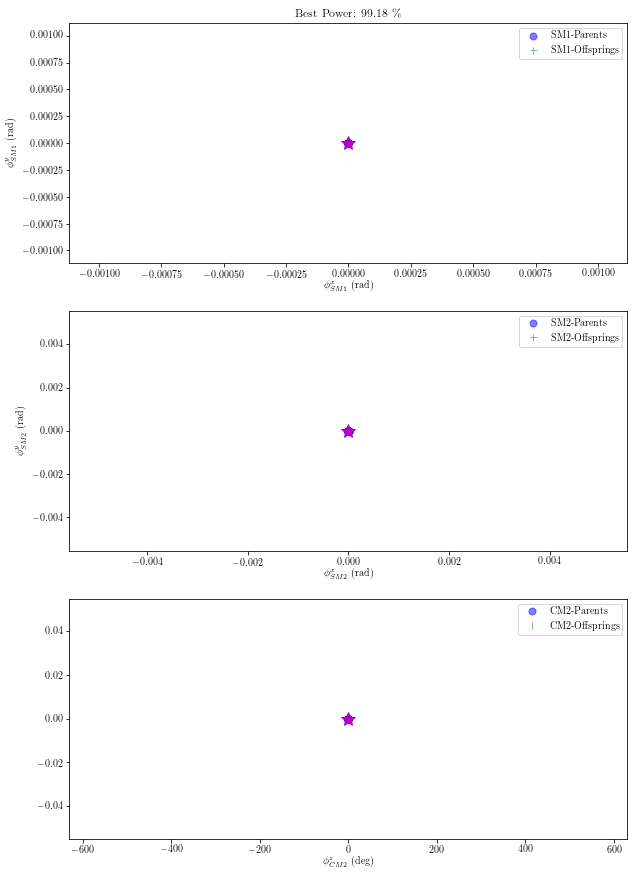

Time: 222.27411007881165, Fittest Parent: [ 2.46697257e-08  6.27972146e-08  1.17377466e-08  2.88067608e-08
 -2.18253467e-03], Fitness: 99.18471131526735


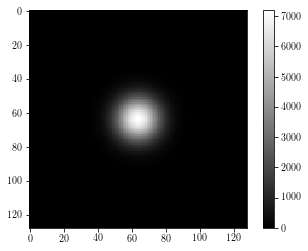



 Gen: 18 Range: 3.1427656813208892e-06 x waist


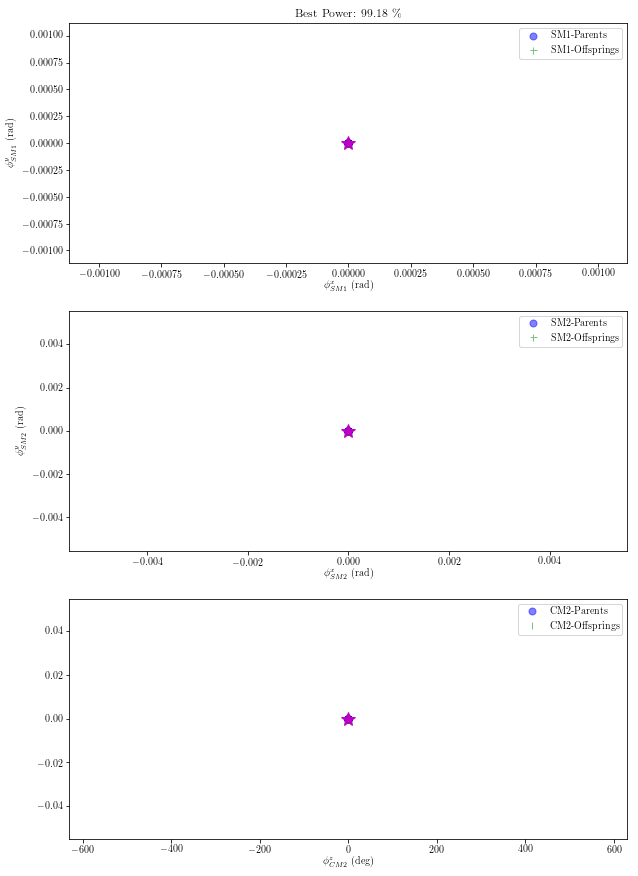

Time: 234.36842679977417, Fittest Parent: [ 1.11815489e-08  8.59908792e-09 -7.57646280e-07 -1.80964708e-07
 -9.15469881e-04], Fitness: 99.1851766363181


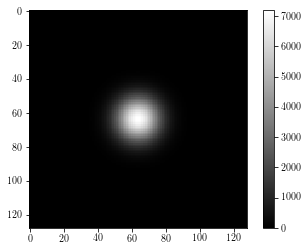



 Gen: 19 Range: 1.5102946502057642e-06 x waist


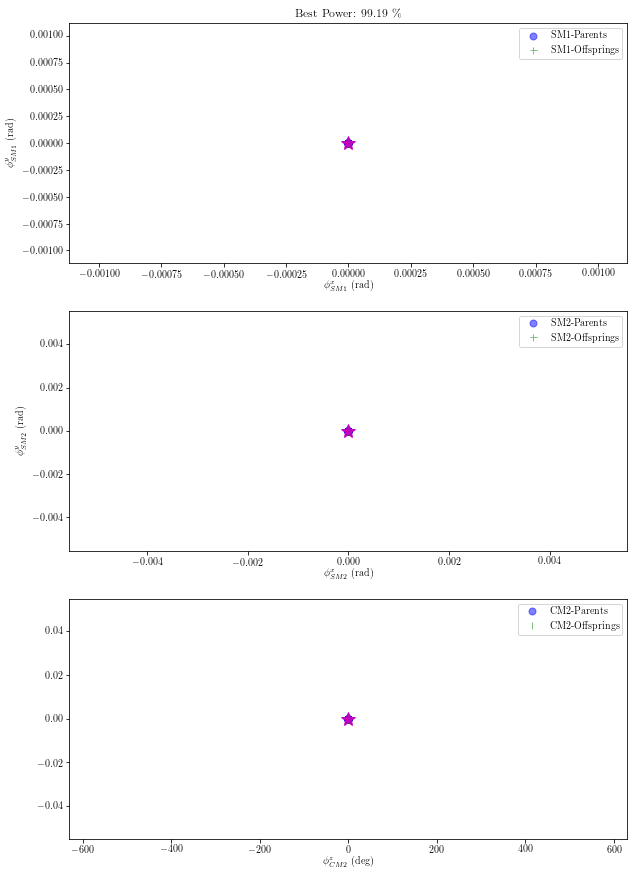

Time: 246.50482606887817, Fittest Parent: [ 1.62632986e-08 -4.54371909e-09 -9.99632406e-07 -1.09881300e-07
  5.02875899e-04], Fitness: 99.18531076777663


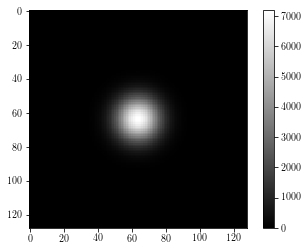



 Gen: 20 Range: 7.257906448442133e-07 x waist


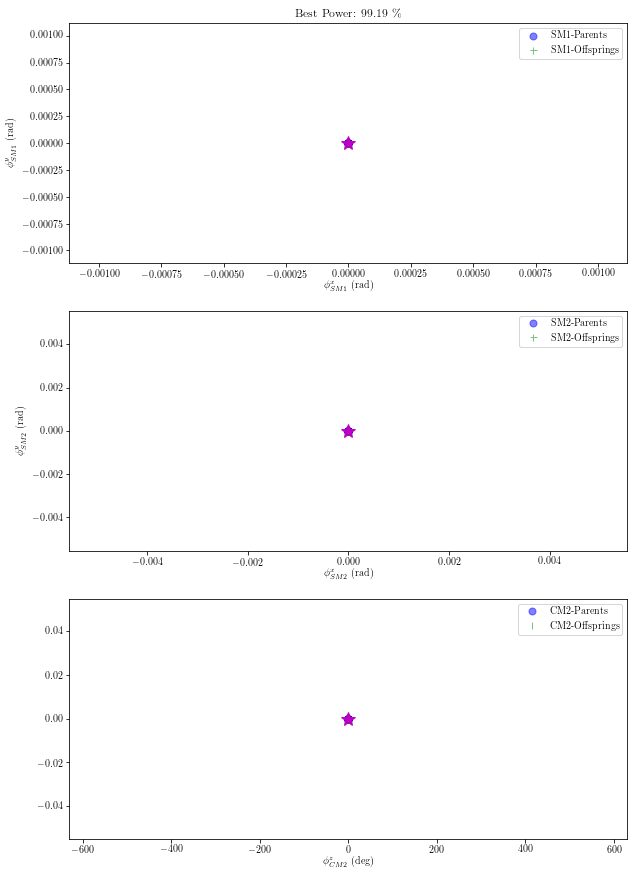

Time: 258.52958726882935, Fittest Parent: [ 5.24358955e-09  5.11761879e-09 -2.45998885e-07  3.25839292e-08
  5.43118637e-04], Fitness: 99.18537956671413


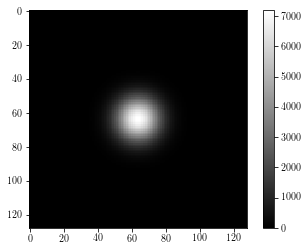



 Gen: 21 Range: 3.4878760914077994e-07 x waist


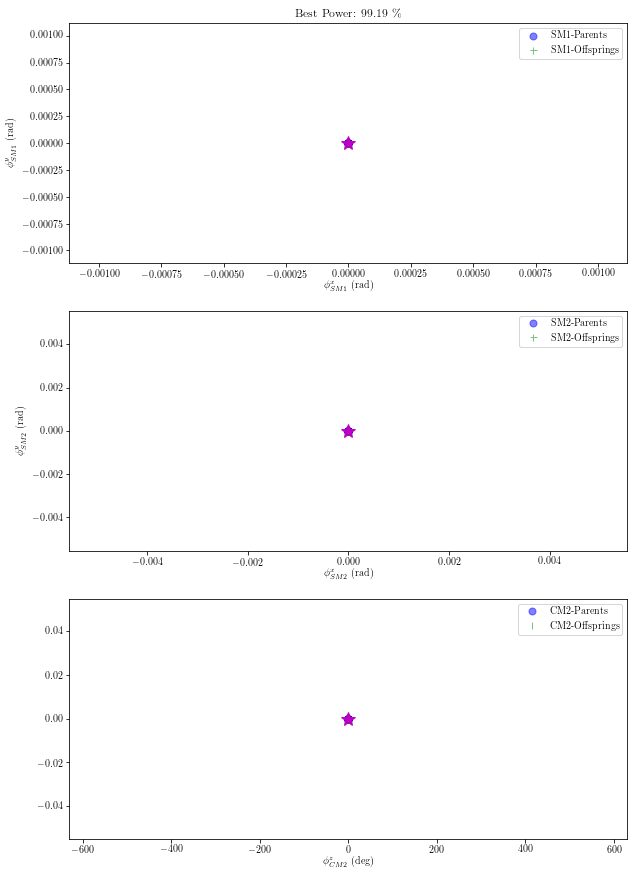

Time: 270.6219620704651, Fittest Parent: [ 8.59186173e-09  1.24988705e-09 -2.52636149e-07 -6.95448775e-09
  2.87069203e-04], Fitness: 99.18548787616973


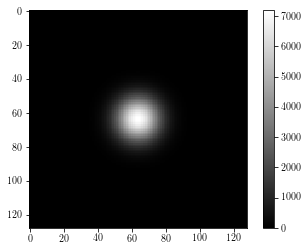



 Gen: 22 Range: 1.676141696704475e-07 x waist


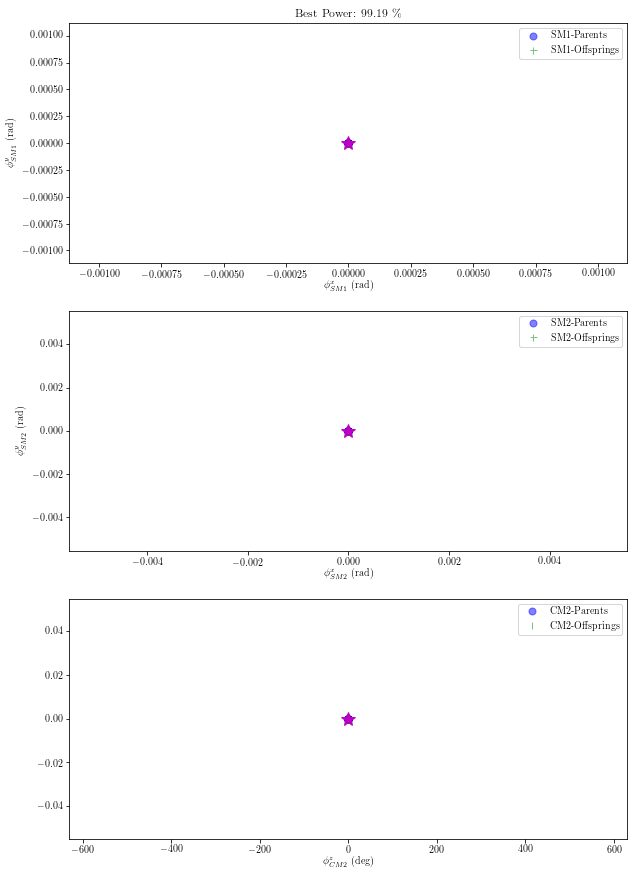

Time: 282.68260884284973, Fittest Parent: [ 6.66962900e-10  1.90546855e-10 -2.59674625e-07 -9.24308969e-09
 -7.66793221e-05], Fitness: 99.18550574466057


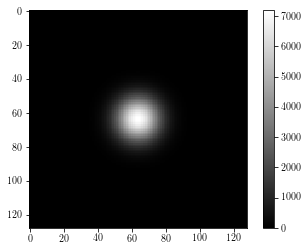



 Gen: 23 Range: 8.054904801097412e-08 x waist


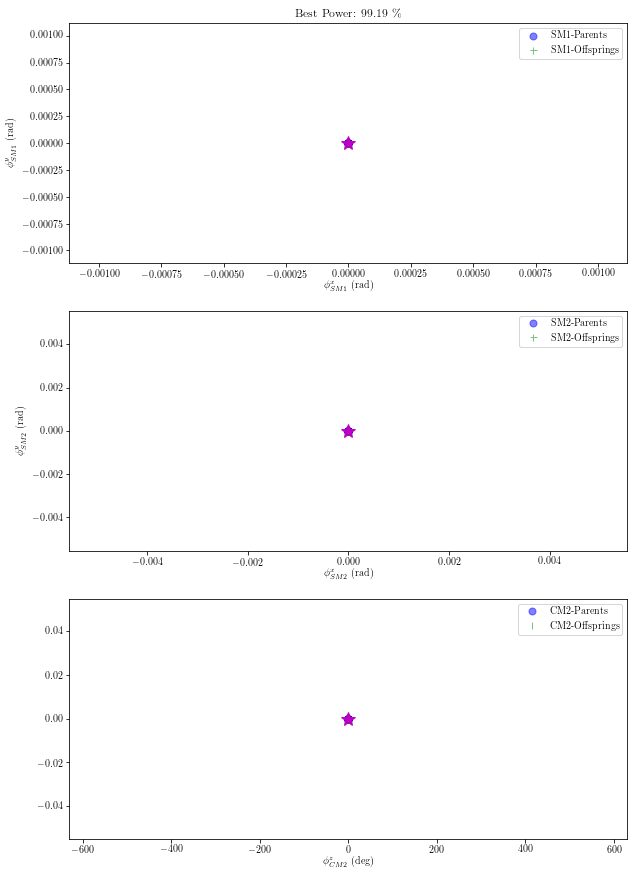

Time: 294.7036557197571, Fittest Parent: [ 5.80620551e-10  4.64166480e-10  1.69967220e-08 -3.17736963e-09
 -6.24657165e-05], Fitness: 99.18551343199893


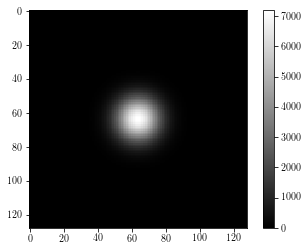



 Gen: 24 Range: 3.8708834391691394e-08 x waist


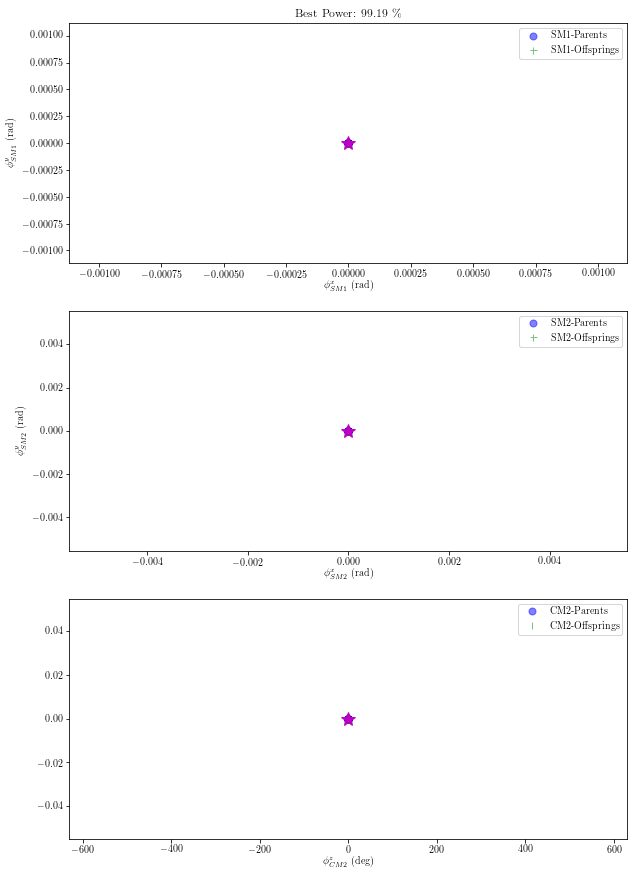

Time: 306.6766085624695, Fittest Parent: [ 8.03030863e-11  2.86476387e-10  4.20557587e-10 -2.46750085e-09
  9.28806604e-05], Fitness: 99.1855165285134


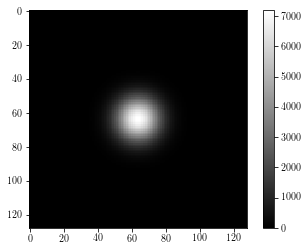

In [7]:
#Creating the initial population of deltas
new_pop_deltas = sample_d(Range, shape=pop_size)
print("\n\nRange:", Range, "x waist")

gen = 0
t0 = time.time()
while True:
    # Shrink range
    Range *= shrink_factor
    print("\n\n Gen: {} Range: {} x waist".format(gen, Range))
    if gen == 0:
        current_beam_status, new_pop_deltas, fitness = calc_pop_fitness(current_beam_status, \
        new_pop_deltas, fitness, only_offsprings=False)
        # Plot the population
        Plot_pop(new_pop_deltas, Range/shrink_factor**(gen+1), fitness, show_parents=False, save_plots=True)
    else:
        current_beam_status, new_pop_deltas, fitness = calc_pop_fitness(current_beam_status, \
        new_pop_deltas, fitness, only_offsprings=True)
        # Plot the population
        Plot_pop(new_pop_deltas, Range/shrink_factor**(gen+1), fitness, show_parents=True, save_plots=True)
    # Selecting the best parents in the population for mating.
    parents, parents_fitness = select_mating_pool(new_pop_deltas, fitness, \
                                                  num_parents_mating, show_the_best=True, save_best=True)
    # Generating next generation using crossover.
    offspring_crossover = crossover(parents, (pop_per_gen - num_parents_mating, num_params))
    # Adding some variations to the offsrping using mutation.
    offspring_mutation = mutation(offspring_crossover, Range)
    # Creating the new population based on the parents and offspring.
    new_pop_deltas[0:num_parents_mating, :] = parents
    new_pop_deltas[num_parents_mating:, :] = offspring_mutation
    fitness[0:num_parents_mating] = parents_fitness
    fitness[num_parents_mating:] *= 0.
    gen += 1
    if (gen == 25): break

## Make gif of the images

In [8]:
import imageio

# GIF of o/p beam images
files = os.listdir(ImagesFolder)
files.sort()
images = []
for filename in files:
    if filename[:3] == 'sca':
        continue
    images.append(imageio.imread(ImagesFolder+'/'+filename))
imageio.mimsave(ImagesFolder + '/movie.gif', images, duration=0.5)

# GIF of scatter plots
images = []
for filename in files:
    if filename[:3] == 'sca':
        images.append(imageio.imread(ImagesFolder+'/'+filename))
imageio.mimsave(ImagesFolder + '/scatter_plot_movie.gif', images, duration=0.5)